## Setup & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd "drive/MyDrive/w266-project/"

[Errno 2] No such file or directory: 'drive/MyDrive/w266-project/'
/content/drive/MyDrive/w266-project


In [3]:
!pip install transformers

     |████████████████████████████████| 2.5MB 10.0MB/s 
     |████████████████████████████████| 3.3MB 48.2MB/s 
     |████████████████████████████████| 901kB 48.9MB/s 


In [13]:
#Imports
import torch
import pandas as pd
import numpy as np
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer

import sklearn
from sklearn.model_selection import train_test_split

## Data

In [64]:
#Read in OLID data

turkish = pd.read_csv("data/Turkish/train.tsv", sep="\t")
greek = pd.read_csv("data/Greek/train.tsv", sep="\t")
english = pd.read_csv("data/olid/olid-training-v1.0.tsv", sep="\t")
danish = pd.read_csv("data/Danish/train.tsv", sep="\t")
arabic_test = pd.read_csv("data/Arabic/test.tsv", sep="\t")
arabic = pd.read_csv("data/Arabic/train.tsv", sep="\t")

amharic = pd.read_csv("data/amharic/amharic_train.csv")

In [91]:
all = pd.concat([turkish,greek,english,danish], axis=0)
all

,id,tweet,subtask_a,subtask_b,subtask_c
0,25210,"Okul senden de nefret ediyorum,erken uyanmak s...",NOT,NaN,NaN
1,16558,"Muhalefetin""vaat""diye sunduğu bir AkParti icra...",OFF,NaN,NaN
2,22028,@USER sadık bir arkadaş on bin akrabaya bedeld...,NOT,NaN,NaN
3,15908,"@USER çok teşekkürler,kurum hizmetiyle alakal...",NOT,NaN,NaN
4,10913,Hafta içinden daha yorucu bir #Haftasonu geçir...,NOT,NaN,NaN
...,...,...,...,...,...
2363,1066,@USER så må hun squ da lære at lave ordentlig ...,NOT,NaN,NaN
2364,2368,[Tråd på /r/SWARJE ](URL,NOT,NaN,NaN
2365,2875,Har de stået i kø i 2 TIMER og så er de mest p...,NOT,NaN,NaN
2366,911,Lige til /r/NorwayPics - dagens subreddit :D,NOT,NaN,NaN


In [10]:
#Read in test
amharic_test = pd.read_csv("data/amharic/amharic_test_reserve.csv")

#Creating new column with 0/1
amharic_test["label"] = np.nan
amharic_test.loc[(amharic_test["subtask_a"] == "OFF"), "label"] = 1
amharic_test.loc[(amharic_test["subtask_a"] == "NOT"), "label"] = 0

amharic_test

,id,tweet,subtask_a,label
0,2767,ገራሚ ትዝብት ነው,NOT,0.0
1,19212,ወድፕፊት እትዮጵያን መግዛት አይችሉም መሆንም አይገባቸውም ምክንያቱም ለኢ...,OFF,1.0
2,15530,ይቺ የበሽተኛ ልጅ,OFF,1.0
3,25421,ታዴ አንተ እኮ የሰውነት የውሀ ልክ ነህ እኔም ትንሽ የሆነ ነገር ብዬ ነ...,OFF,1.0
4,26281,ቅቅቅቅቅ ጎጠኛ ሌባ,OFF,1.0
...,...,...,...,...
995,21228,ዳኝ እንድክ ፀረ ህገ መንግስ ትወናለህ ብዬ አለምኔኩምትግርኛ ለምን በ ...,NOT,0.0
996,20165,አማራ እንደ አብን ቁርጠኛ የፖለቲካ አመራሮች በማጣቱ ምክንያት በኦሮምያ ...,NOT,0.0
997,2372,አማራ ንቃ እንደ ኪራይ እቃ መቸም አትነቃ ከነቃን ግን በተባበረ ክንዳችን...,OFF,1.0
998,20424,ይቅርታ ሰዎች ብዙ ችግር እንዳለው ባውቅም የመጣውም የኛው ሰዎችም ገረድ...,OFF,1.0


In [94]:
print(np.sum(amharic_test.subtask_a=="OFF")/np.size(amharic_test.subtask_a), "is the ratio of offensive to total tweets in the train/dev set")

0.52 is the ratio of offensive to total tweets in the train/dev set


## Preparing to run BERT

In [69]:
#From https://mccormickml.com/2019/07/22/BERT-fine-tuning/

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [70]:
tokenizer = BertTokenizer.from_pretrained('Davlan/bert-base-multilingual-cased-finetuned-amharic')


In [71]:
#Some hyperparameters

L_RATE = 0.000005 #1e-5 # need to change this potentially
MAX_LEN = 128

NUM_EPOCHS = 3
BATCH_SIZE = 16

In [73]:
MAX_LEN = 55 # This value could be set as 256, 512 etc.


#From Josh's XLMR
def create_tensors( all_training_sets ):
    
    _all_labels = []
    _all_input_ids = []
    _all_attn_masks = []
    
    for t_set in all_training_sets:
        new_ids, new_masks, new_labels = tokenize_dataset(t_set)
        _all_input_ids = [*_all_input_ids, *new_ids]
        _all_attn_masks = [*_all_attn_masks, *new_masks]
        _all_labels = [*_all_labels, *new_labels]
        
    # Convert each Python list of Tensors into a 2D Tensor matrix.
    _all_input_ids = torch.cat(_all_input_ids, dim=0)
    _all_attn_masks = torch.cat(_all_attn_masks, dim=0)

    # Cast the labels list to a Tensor.
    _all_labels_tensor = torch.tensor(_all_labels)
    
    return _all_input_ids, _all_attn_masks, _all_labels_tensor, _all_labels

def tokenize_dataset( training_set ):
    
    _labels = []
    _ids = []
    _masks = []
    
    # look through all records
    for index, row in training_set.iterrows():
        encoded_dict = tokenizer.encode_plus(
                    row['tweet'], # Sentence to encode.
                    add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                    max_length = MAX_LEN,           # Pad or truncate.
                    padding = 'max_length',
                    return_attention_mask = True,   # Construct attn. masks.
                    return_tensors = 'pt', # Return pytorch tensors.
                    truncation = True    #use to avoid warning      
                   )

        # Add this example to our lists.
        _ids.append(encoded_dict['input_ids'])
        _masks.append(encoded_dict['attention_mask'])
        #print(row['label'])
        #_labels.append(row['label'])
        if row['subtask_a'] == 'NOT':
            _labels.append(0)
        else:
            _labels.append(1)
    
    return _ids, _masks, _labels

datasets = [all]
all_input_ids, all_attn_masks, all_labels_tensor, all_labels = create_tensors(datasets)


print('   DONE. {:,} examples.'.format(len(all_labels)))

   DONE. 84,845 examples.


In [74]:

datasets = [amharic_test]
test_input_ids_amharic, test_attn_masks_amharic, test_labels_amharic_tensor, test_labels_amharic = create_tensors(datasets)

print('   DONE. {:,} examples.'.format(len(test_labels_amharic)))

   DONE. 1,000 examples.


In [75]:
#From Josh's XLMR notebook

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Specify our batch size.
batch_size = 16 #For fine-tuning BERT, authors recommended 16 or 32 batch size

# Construct a TensorDataset from the encoded examples.
prediction_dataset = TensorDataset(test_input_ids_amharic, test_attn_masks_amharic, test_labels_amharic_tensor)

# And a dataloader for handling batching.
prediction_dataloader = DataLoader(prediction_dataset, batch_size=batch_size)

In [76]:
#From Josh's XLMR notebook & https://mccormickml.com/2019/07/22/BERT-fine-tuning/

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(all_input_ids, all_attn_masks, all_labels_tensor)

# Create a 90-10 train-validation split. Calculate the number of samples to 
# include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


# Create the DataLoaders for our training sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

76,360 training samples
8,485 validation samples


In [77]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "Davlan/bert-base-multilingual-cased-finetuned-amharic", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-amharic were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model check

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [78]:
# From https://mccormickml.com/2019/07/22/BERT-fine-tuning/
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [79]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = L_RATE, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [80]:
from transformers import get_linear_schedule_with_warmup


# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * NUM_EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [81]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [82]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [83]:
import random

#From https://mccormickml.com/2019/07/22/BERT-fine-tuning/

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, NUM_EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, NUM_EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        #print(b_labels)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        (loss, logits) = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels, return_dict=False)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  4,773.    Elapsed: 0:00:09.
  Batch    80  of  4,773.    Elapsed: 0:00:18.
  Batch   120  of  4,773.    Elapsed: 0:00:27.
  Batch   160  of  4,773.    Elapsed: 0:00:35.
  Batch   200  of  4,773.    Elapsed: 0:00:44.
  Batch   240  of  4,773.    Elapsed: 0:00:52.
  Batch   280  of  4,773.    Elapsed: 0:01:01.
  Batch   320  of  4,773.    Elapsed: 0:01:09.
  Batch   360  of  4,773.    Elapsed: 0:01:18.
  Batch   400  of  4,773.    Elapsed: 0:01:27.
  Batch   440  of  4,773.    Elapsed: 0:01:35.
  Batch   480  of  4,773.    Elapsed: 0:01:44.
  Batch   520  of  4,773.    Elapsed: 0:01:52.
  Batch   560  of  4,773.    Elapsed: 0:02:01.
  Batch   600  of  4,773.    Elapsed: 0:02:10.
  Batch   640  of  4,773.    Elapsed: 0:02:18.
  Batch   680  of  4,773.    Elapsed: 0:02:27.
  Batch   720  of  4,773.    Elapsed: 0:02:36.
  Batch   760  of  4,773.    Elapsed: 0:02:44.
  Batch   800  of  4,773.    Elapsed: 0:02:53.
  Batch   840  of

### Training Eval

In [84]:
#Summary of the training

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.57,0.57,0.71,0:17:06,0:00:30
2,0.54,0.54,0.73,0:17:06,0:00:30
3,0.50,0.54,0.74,0:17:06,0:00:30


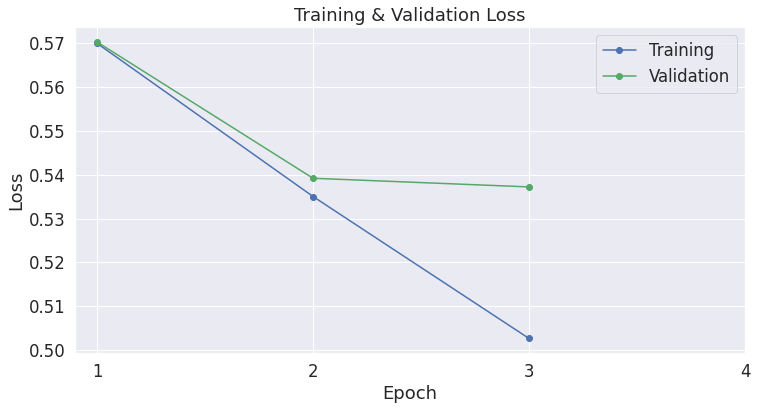

In [85]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Test Evaluation

In [86]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids_amharic)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,000 test sentences...
    DONE.


In [87]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# For each sample, pick the label (0, 1) with the highest score.
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [88]:
# Tally the number of correct predictions to get our accuracy.
accuracy = (predicted_labels == flat_true_labels).mean()

print('mBERT Prediction accuracy for amharic: {:.3f}'.format(accuracy))

mBERT Prediction accuracy for amharic: 0.648


In [89]:
from sklearn.metrics import f1_score

score = f1_score(flat_true_labels, predicted_labels)
print('mBERT Prediction f1 score for amharic: {:.3f}'.format(score))

mBERT Prediction f1 score for amharic: 0.673
